***Final Project Code Notebook: Interpolating precipitation and plant production across the range!***
Nicole Kaplan, May 5, 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages-and-establish-working-directory" data-toc-modified-id="Import-packages-and-establish-working-directory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages and establish working directory</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Inverse-Distance-Weighting" data-toc-modified-id="Inverse-Distance-Weighting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inverse Distance Weighting</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Classification</a></span></li></ul></li><li><span><a href="#Get-Pasture-Data" data-toc-modified-id="Get-Pasture-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get Pasture Data</a></span></li><li><span><a href="#Get-Precipitation-Data-and-melt-format" data-toc-modified-id="Get-Precipitation-Data-and-melt-format-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Precipitation Data and melt format</a></span><ul class="toc-item"><li><span><a href="#Get-Primary-Production-Data-and-Georeference" data-toc-modified-id="Get-Primary-Production-Data-and-Georeference-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Get Primary Production Data and Georeference</a></span></li><li><span><a href="#Georeference-Precipitation-Data,-Subset-and-Resample" data-toc-modified-id="Georeference-Precipitation-Data,-Subset-and-Resample-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Georeference Precipitation Data, Subset and Resample</a></span></li><li><span><a href="#Join-seasonal-Precipitation-with-Production-Data" data-toc-modified-id="Join-seasonal-Precipitation-with-Production-Data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Join seasonal Precipitation with Production Data</a></span></li><li><span><a href="#Generate-np-Arrays-as-Input-into-IDW-Function" data-toc-modified-id="Generate-np-Arrays-as-Input-into-IDW-Function-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Generate np Arrays as Input into IDW Function</a></span></li></ul></li><li><span><a href="#Exploratory-Plots" data-toc-modified-id="Exploratory-Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exploratory Plots</a></span><ul class="toc-item"><li><span><a href="#CARM-Study-Site" data-toc-modified-id="CARM-Study-Site-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>CARM Study Site</a></span></li><li><span><a href="#CARM-Experimental-Design" data-toc-modified-id="CARM-Experimental-Design-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>CARM Experimental Design</a></span></li><li><span><a href="#Frequency-plots-of-precipitation-and-production" data-toc-modified-id="Frequency-plots-of-precipitation-and-production-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Frequency plots of precipitation and production</a></span></li><li><span><a href="#Scatter-Plots-of-Precipitation-and-Production" data-toc-modified-id="Scatter-Plots-of-Precipitation-and-Production-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Scatter Plots of Precipitation and Production</a></span></li></ul></li><li><span><a href="#Run-IDW-and-Classification-Functions" data-toc-modified-id="Run-IDW-and-Classification-Functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run IDW and Classification Functions</a></span></li><li><span><a href="#Plot-PPT-IDW-Results" data-toc-modified-id="Plot-PPT-IDW-Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot PPT IDW Results</a></span></li></ul></div>

# Import packages and establish working directory

In [1]:
# Import Packages
import warnings
from glob import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import rasterio as rio
import geopandas as gpd
from scipy.spatial import cKDTree
from datetime import datetime
import earthpy as et

import folium
from folium import plugins

# Set seaborn plot style
sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

warnings.simplefilter('ignore')

In [2]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'ea_python_spatial', 'Final_Project', 'data'))

# Create output folder
output_path = os.path.join("output_maps")

# Functions
## Inverse Distance Weighting

In [3]:
# Class containing functions for inverse distance weighing

"""
    Inverse distance weighting (IDW)
    --------------------------------

    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.

    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting

    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.

    Returns:
    --------
        tree instance: object
        
    Notes:
    --------
    Wrapper around ___intit____().
    
   """


class tree(object):  # use tree as the name of the function
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize)
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):

        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):

        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / \
            np.sum(1./self.distances, axis=1)

        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        return self.__call__(X, k, eps, p, regularize_by)

## Classification

In [4]:
def classify(to_class_arr, class_list):
    """
    Function classifies numpy arrays using classes defined

    Parameters
    ----------
    to_class_arr : numpy arr
        arrays that need to be classified

    Returns
    ------
    classified_arr : numpy arr
        arrays with classified values

    """
    # Calculate classes of precipitation amount
    class_bins = class_list
    classified_arr = np.digitize(to_class_arr, class_bins)

    return classified_arr

# Get Pasture Data

In [5]:
# Get shape filez for site and pasture boundaries
pasture_path = os.path.join("vector_data",
                            "CPER_Pastures_2014_AGM_TGM_pDOG.shp")
pasture_org = gpd.read_file(pasture_path)
carm_pastures = pasture_org[pasture_org['Treatment'].isin(["TGM", "AGM"])]
AGM_trt = pasture_org[pasture_org['Treatment'].isin(["AGM"])]

cper_bndy_path = os.path.join("vector_data", "CPERBody.shp")
cper_bndy = gpd.read_file(cper_bndy_path)

# Get Precipitation Data and melt format

In [6]:
# Get 2019 precipitation data (mm)
ppt_path = os.path.join("abiotic_data",
                        "hydromet2019_gapfilled_1-23-20.csv")
ppt_data = pd.read_csv(ppt_path, parse_dates=['date'])

# Get point data for ppt gauges to join by pasture to values
ppt_locations_path = os.path.join("abiotic_data",
                                  "ppt_locations.csv")
ppt_locations = pd.read_csv(ppt_locations_path)

# Melt ppt data format from wide to long
ppt_data_long = pd.melt(ppt_data, id_vars=["date"], var_name=["pasture"])

## Get Primary Production Data and Georeference

In [7]:
# Get 2019 production data for plots
production_path = os.path.join("biotic_data",
                               "GPerMeterSquared.csv")
prod_data = pd.read_csv(production_path)

prod_data_locs_df = gpd.GeoDataFrame(prod_data, geometry=gpd.points_from_xy(
    prod_data.Easting,  prod_data.Northing), crs="epsg:32613")

prod_list = prod_data_locs_df[['kgPerHa']]
prod_xy = prod_data_locs_df[['Easting', 'Northing']]


# Get 2019 production data for pastures
past_production_path = os.path.join("biotic_data",
                                    "CARM_2019_biomass_gains.csv")
past_prod_data = pd.read_csv(past_production_path)

## Georeference Precipitation Data, Subset and Resample

In [8]:
# Join PPT data to pt location and geo-reference and create df of ppt gauges
ppt_data_locs = pd.merge(ppt_data_long,
                         ppt_locations[['pasture',
                                        'Easting_UTM', 'Northing_UTM']], on='pasture')
ppt_data_locs_df = gpd.GeoDataFrame(ppt_data_locs, geometry=gpd.points_from_xy(
    ppt_data_locs.Easting_UTM,  ppt_data_locs.Northing_UTM), crs="epsg:32613")


# Subset ppt dataframe from May - Oct, when the cattle are present
ppt_data_locs_df['date'] = pd.to_datetime(
    ppt_data_locs_df['date'], format='%Y%d%b')
date1 = datetime.strptime('2019-04-19', '%Y-%m-%d')
date2 = datetime.strptime('2019-09-08', '%Y-%m-%d')
ppt_data_locs_df = ppt_data_locs_df.loc[(
    ppt_data_locs_df['date'] > date1) & (ppt_data_locs_df['date'] < date2)]


# Resample bi-weekly to generate cumulative rainfall
ppt_data_locs_df_wk = (ppt_data_locs_df.set_index(
    'date').groupby('pasture').resample('1W').sum().reset_index())
ppt_data_locs_df_season = (ppt_data_locs_df.set_index(
    'date').groupby('pasture').sum().reset_index())
season_value = ppt_data_locs_df_season['value']

## Join seasonal Precipitation with Production Data

In [9]:
# Join seasonal ppt with production data in pastures
ppt_production_df = pd.merge(past_prod_data, ppt_data_locs_df_season[['pasture', 'value',
                                        'Easting_UTM', 'Northing_UTM']], left_on="Pasture", right_on="pasture", how="left")

# Join seasonal ppt with production data in plots
prod_ppt_data = pd.merge(prod_data_locs_df, ppt_data_locs_df_season[['pasture', 'value'
                                                                    ]], left_on="pasture", right_on="pasture", how="left")

## Generate np Arrays as Input into IDW Function

In [10]:
# Generate a list of x, y coordinates of the sample sites
ppt_xy_list = []
ppt_xy = ppt_data_locs_df[['Easting_UTM', 'Northing_UTM']]
ppt_xy_list.append(np.array(ppt_xy.drop_duplicates()))

# Generate list of dates to get ppt values
ppt_dates = ppt_data_locs_df_wk["date"].unique()
ppt_dates_str = np.datetime_as_string(ppt_dates, unit="D")

# Loop through ppt data to create a array for each week
value_list = []
for i in ppt_dates:
    ppt_date = ppt_data_locs_df_wk.loc[ppt_data_locs_df_wk['date'] == i, [
        'value']]
    value_list.append(ppt_date)

# Exploratory Plots 

## CARM Study Site

In [11]:
# Plot where CPER is in Colorado
CPER_map = folium.Map(location=[40.812193,  -104.753318],
                      tiles="Stamen Terrain")

folium.Marker(location=[40.812193,  -104.753318],
              popup="USDA ARS Central Plains Experimental Range",
              icon=folium.Icon()
              ).add_to(CPER_map)
CPER_map

## CARM Experimental Design

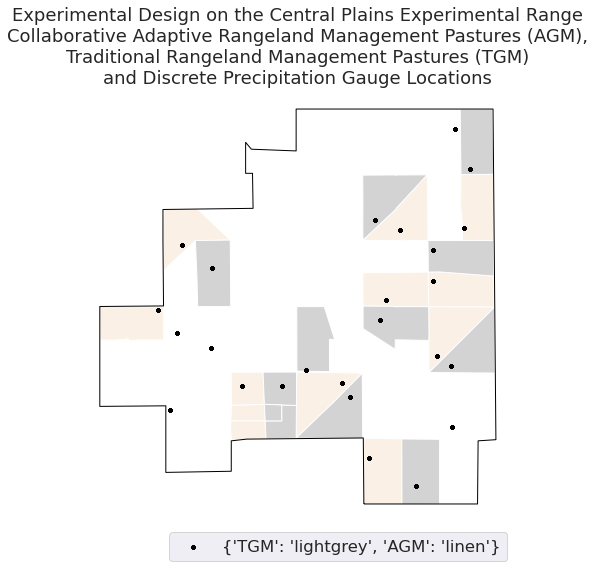

In [12]:
# Plot CARM treatment and ppt gauge locations
trt_symbols = {"TGM": "lightgrey",
               "AGM": "linen"}


fig, ax = plt.subplots(figsize=(8, 8))

for past_trt, data in carm_pastures.groupby("Treatment"):
    color = trt_symbols[past_trt]
    label = past_trt
    data.plot(color=color,
              ax=ax,
              label=label)

cper_bndy.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
ppt_data_locs_df.plot(alpha=1, ax=ax, color="black", marker="P", markersize=10)

# labels used here to ensure labels show up
ax.legend(bbox_to_anchor=(1, 0), labels=[trt_symbols])

ax.set(title="Experimental Design on the Central Plains Experimental Range\n"
       "Collaborative Adaptive Rangeland Management Pastures (AGM),\n"
       "Traditional Rangeland Management Pastures (TGM)\n"
       "and Discrete Precipitation Gauge Locations")

ax.set_axis_off()
filepath = os.path.join(output_path, "exp_design.jpg")
plt.savefig(filepath, dpi=300)

plt.show()

## Frequency plots of precipitation and production

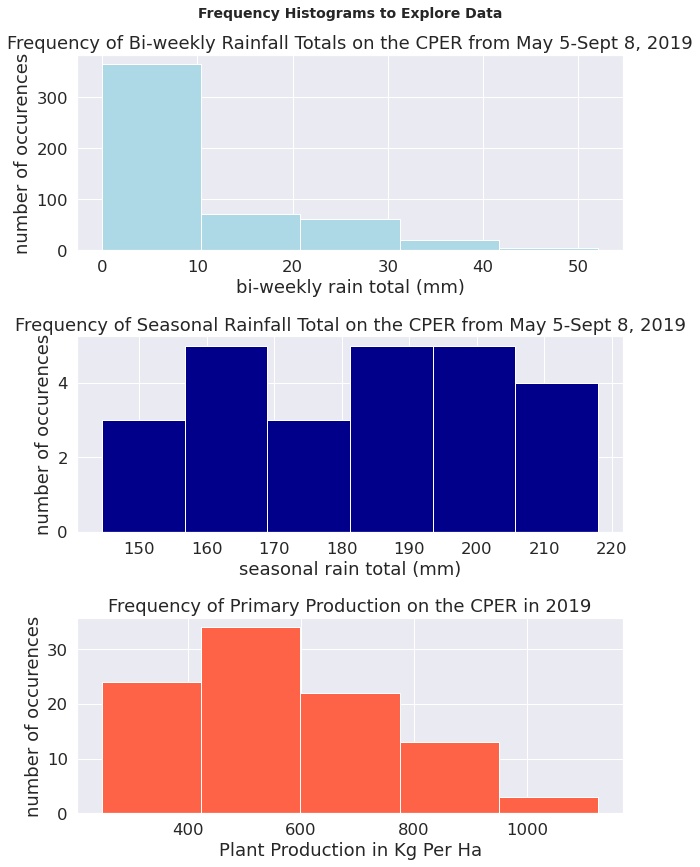

In [13]:
# Plot histogram of bi-weekly rainfall amounts

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), tight_layout=True)


fig.suptitle("Frequency Histograms to Explore Data", fontsize=14, weight='bold',
             x=.5, y=1.01)

ppt_data_locs_df_wk.hist(ax=ax1, column="value", bins=5, color="lightblue")
ax1.set(xlabel="bi-weekly rain total (mm)",
        ylabel="number of occurences", 
        title="Frequency of Bi-weekly Rainfall Totals on the CPER from May 5-Sept 8, 2019")

ppt_data_locs_df_season.hist(ax=ax2, column="value", bins=6, color="darkblue")
ax2.set(xlabel="seasonal rain total (mm)",
        ylabel="number of occurences", 
        title="Frequency of Seasonal Rainfall Total on the CPER from May 5-Sept 8, 2019")

prod_data_locs_df.hist(ax=ax3, column="kgPerHa", bins=5, color="tomato")
ax3.set(xlabel="Plant Production in Kg Per Ha",
        ylabel="number of occurences", 
        title="Frequency of Primary Production on the CPER in 2019")

filepath = os.path.join(output_path, "FreqHistograms.jpg")
plt.savefig(filepath, dpi=300)

## Scatter Plots of Precipitation and Production

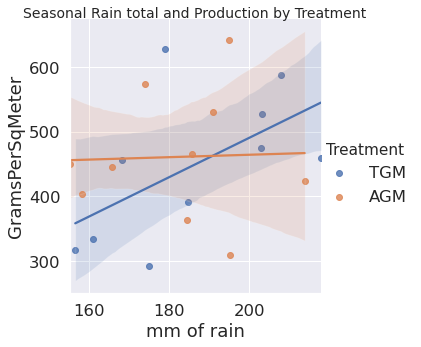

In [14]:
# Scatter plot and regression model to explore Seasonal Rain total and production by treatment
lm = sns.lmplot(x="value", y="GramsPerSqMeter",
                data=ppt_production_df, hue='Treatment')
plt.xlabel("mm of rain")
fig = lm.fig
fig.suptitle("Seasonal Rain total and Production by Treatment", fontsize=14)

filepath = os.path.join(output_path, 'biomass_ppt.jpg')
plt.savefig(filepath, dpi=300)
plt.show()

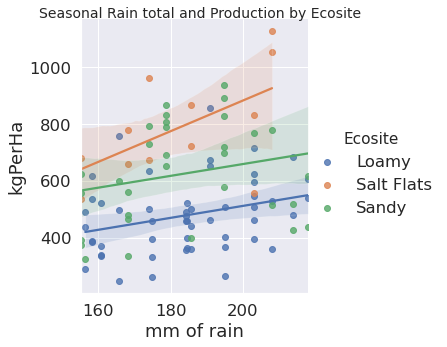

In [15]:
# Scatter plt to explore Seasonal Rain total and production by ecosite
lm = sns.lmplot(x="value", y="kgPerHa", data=prod_ppt_data, hue='Ecosite')
plt.xlabel("mm of rain")
fig = lm.fig
fig.suptitle("Seasonal Rain total and Production by Ecosite", fontsize=14)
filepath = os.path.join(output_path, 'biomass_ppt_ecosite.jpg')
plt.savefig(filepath, dpi=300)

# Run IDW and Classification Functions

In [16]:
# Create grid from CPER boundary
spacing_x = np.linspace(517624.84375, 527273.75, 40)
spacing_y = np.linspace(4514740.5, 4524361.0, 40)
X2 = np.meshgrid(spacing_x, spacing_y)
X2 = np.reshape(X2, (2, -1)).T

In [17]:
# Assign data to be interpolated for one date
X = np.reshape(ppt_xy_list, (2, -1)).T  # site points as array

In [18]:
# Run function and return list of interpolated dataframes for seasonal precipitation
season_list_ppt = [150, 160, 170, 180, 190, 200, 210, np.inf]
z = np.array(season_value)  # values as array
model = tree(X, z)
model.fit()
results = model.transform(X2)
ppt_season_class = classify(results, season_list_ppt)
idw = np.column_stack((results, X2, ppt_season_class))
idw_df_season = gpd.GeoDataFrame(
    idw, geometry=gpd.points_from_xy(idw[:, 1], idw[:, 2]))

In [19]:
# Run function and return list of interpolated dataframes for time-series precipitation
idw_df_list = []
class_list_ppt = [0, 1, 5, 10, 15, 20, 25, 30, np.inf]
for i in value_list:
    z=np.array(i) # values as array
    model = tree(X, z)
    model.fit()
    results = model.transform(X2) 
    ppt_class = classify(results, class_list_ppt)
    idw = np.column_stack((results, X2, ppt_class))
    idw_df = gpd.GeoDataFrame(idw, geometry=gpd.points_from_xy(idw[:,1], idw[:,2]))
    idw_df_list.append(idw_df) 


In [20]:
# Run function and return list of interpolated dataframes for production
class_list_prod = [400, 500, 600, 700, 800, 900, np.inf]

z = np.array(prod_list)  # values as array
model = tree(X, z)
model.fit()
results = model.transform(X2)
prod_class = classify(results, class_list_prod)
idw = np.column_stack((results, X2, prod_class))
idw_df_production = gpd.GeoDataFrame(
    idw, geometry=gpd.points_from_xy(idw[:, 1], idw[:, 2]))

# Plot PPT IDW Results

In [21]:
# Colors for mapping interpolated time-series 2 weeks rainfall
colors = ["mintcream", "aquamarine", "greenyellow", "lightgreen",
          "yellowgreen", "seagreen", "forestgreen", "darkgreen"]
cmap = ListedColormap(colors)
classes = [1, 2, 3, 4, 5, 6, 7, 8]
class_names = {1: "no rain", 2: "10mm",
               3: "20mm", 4: "30mm", 5: "40mm", 6: "50mm", 7: "60mm", 8: ">70mm"}
class_dict = {1: "mintcream", 2: "aquamarine", 3: "greenyellow", 4: "lightgreen", 5: "yellowgreen",
              6: "seagreen", 7: "forestgreen", 8: "darkgreen"}

# Production data
prod_class_dict = {1: "lightyellow", 2: "peachpuff",
                   3: "coral", 4: "tomato", 5: "dakred", 6: "fuchsia"}
prod_colors = ["lightyellow", "peachpuff",
               "coral", "tomato", "darkred", "fuchsia"]
prod_cmap = ListedColormap(prod_colors)

# Seasonal total
season_colors = ["powderblue", "lightblue", "skyblue",
                 "cornflowerblue", "steelblue", "darkblue", "indigo"]
season_cmap = ListedColormap(season_colors)

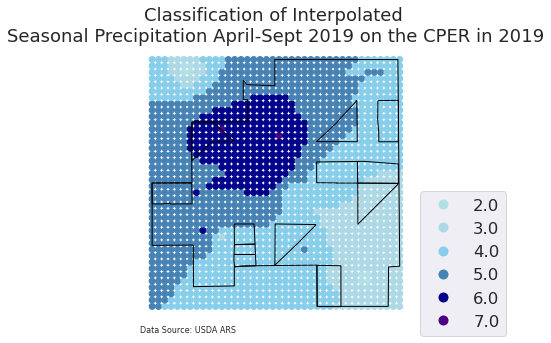

In [22]:
# Plot interpolation of seasonal precipitation

fig, ax = plt.subplots(figsize=(5, 5))

idw_df_season.plot(column=idw_df_season[3],
                   categorical=True,
                   legend=True,
                   cmap=season_cmap,
                   ax=ax)
cper_bndy.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
AGM_trt.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)

ax.text(0, -.05, 'Data Source: USDA ARS', transform=ax.transAxes, fontsize=8)
ax.set(title="Classification of Interpolated \n"
       "Seasonal Precipitation April-Sept 2019 on the CPER in 2019")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.5))
ax.set_axis_off()

filepath = os.path.join(output_path, 'seasonal_ppt.jpg')
plt.savefig(filepath, dpi=300)

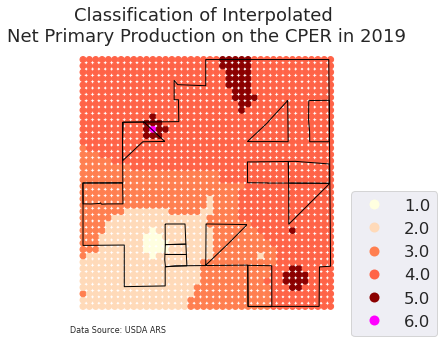

In [23]:
# Plot seasonal total of preciptiation
fig, ax = plt.subplots(figsize=(5, 5))

idw_df_production.plot(column=idw_df_production[3],
                       categorical=True,
                       legend=True,
                       cmap=prod_cmap,
                       ax=ax)
cper_bndy.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
AGM_trt.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)

ax.text(0, -.05, 'Data Source: USDA ARS', transform=ax.transAxes, fontsize=8)
ax.set(title="Classification of Interpolated \n"
       "Net Primary Production on the CPER in 2019")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.5))
ax.set_axis_off()

filepath = os.path.join(output_path, 'production.jpg')
plt.savefig(filepath, dpi=300)

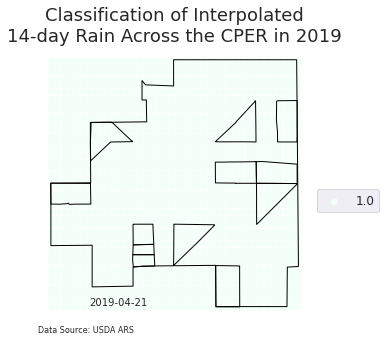

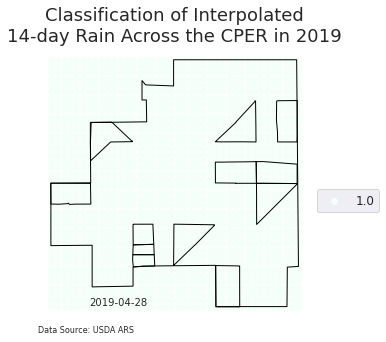

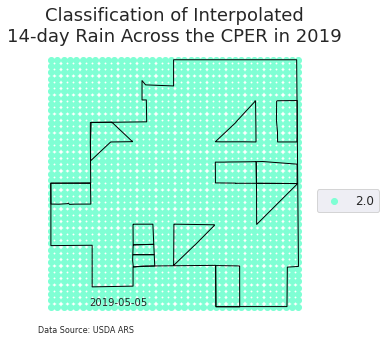

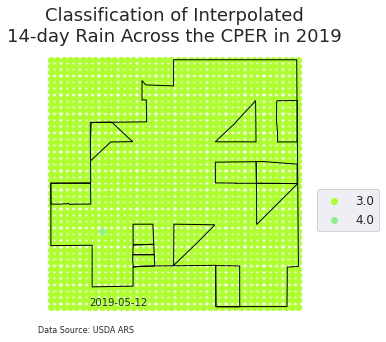

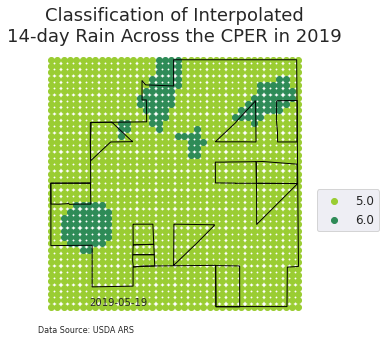

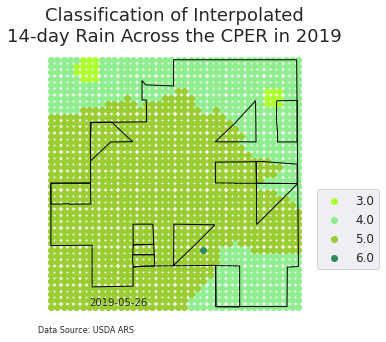

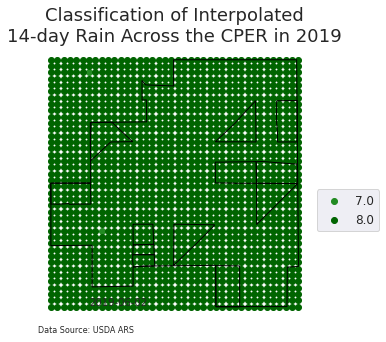

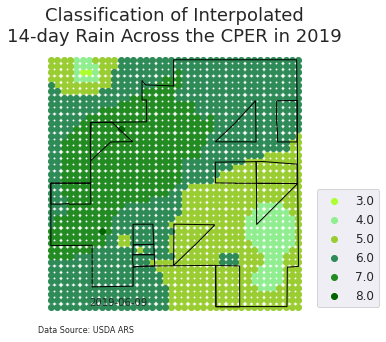

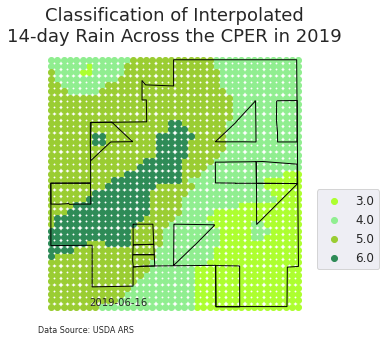

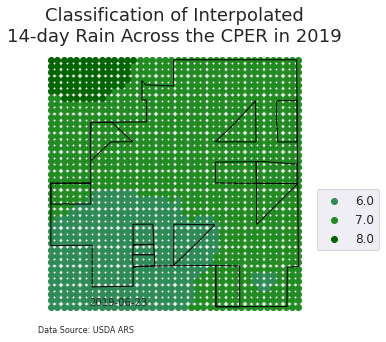

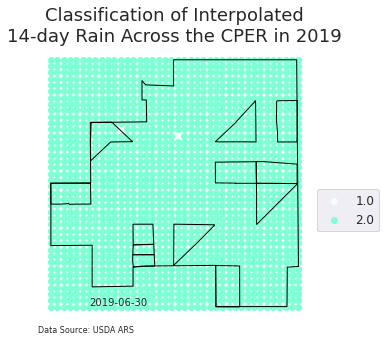

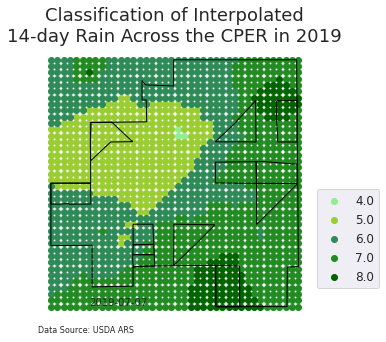

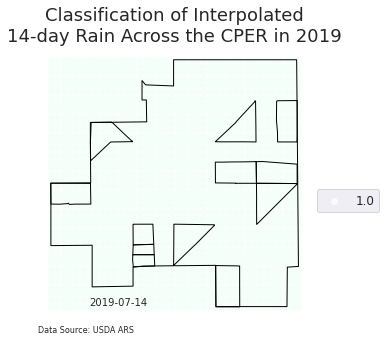

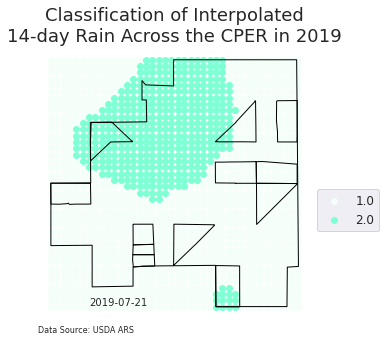

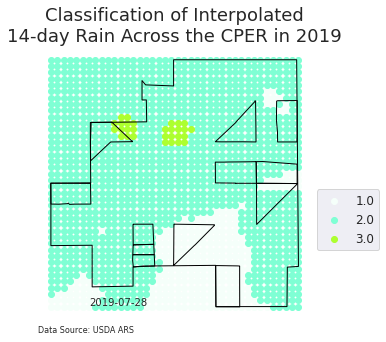

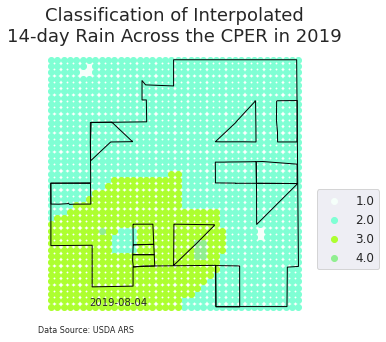

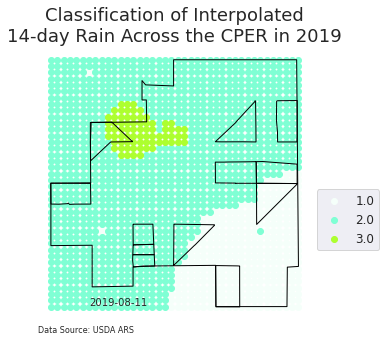

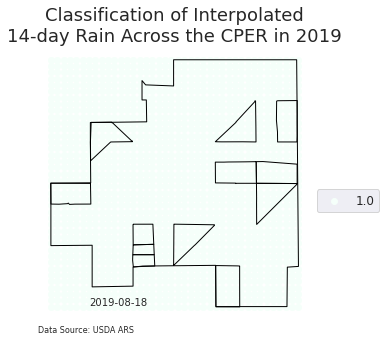

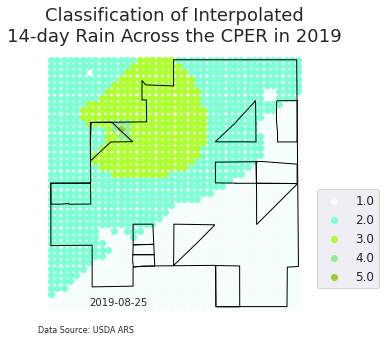

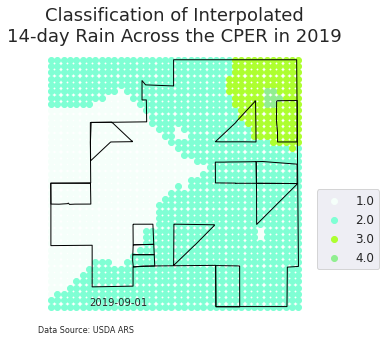

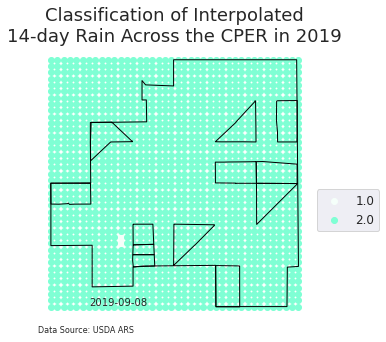

In [24]:
# Plot time-series PPT bi-weekly
for i, date in zip(idw_df_list, ppt_dates_str):

    fig, ax = plt.subplots(figsize=(5, 5))

    for ctype, data in i.groupby([3]):
        color = class_dict[ctype]
        data.plot(color=color, ax=ax, label=ctype)
    cper_bndy.plot(alpha=1, ax=ax, color="none",
                   edgecolor="black", linewidth=1)
    AGM_trt.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)

    ax.text(0, -.05, 'Data Source: USDA ARS',
            transform=ax.transAxes, fontsize=8)
    ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
    ax.set(title="Classification of Interpolated\n"
           "14-day Rain Across the CPER in 2019")

    plt.annotate(date, xy=(.23, .1), xycoords='figure fraction',
                 horizontalalignment='left', verticalalignment='bottom',
                 fontsize=10)
    ax.set_axis_off()

    filepath = os.path.join(output_path, date+'_ppt.jpg')
    plt.savefig(filepath, dpi=300)